### Spatio-Temporal Crime Prediction (for Physical Crime)
**Aim:** Predict the probability ($P$) that a crime will occur in a specific tile at a specific time. To direct patrol units (beats) to perform "proactive presence" in these specific tiles during their shift.

### Setup


In [79]:
# Install required packages (run once if needed)
!pip install geopandas h3 xgboost scikit-learn pandas numpy matplotlib seaborn joblib contextily --quiet

In [80]:
# =============================================================================
# IMPORTS
# =============================================================================
# Data manipulation
import pandas as pd
import numpy as np
import geopandas as gpd
import h3
from shapely.geometry import Polygon

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx # Added contextily import

# Math utilities
from math import radians  # For converting degrees to radians (used in Haversine formula)

# File I/O
import json
import joblib  # For saving/loading sklearn models
import os

# Machine Learning
import xgboost as xgb  # Gradient boosting library
from sklearn.ensemble import RandomForestClassifier  # Bagging ensemble method
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder  # For categorical encoding in pipelines
from sklearn.compose import ColumnTransformer  # Apply different transforms to different columns
from sklearn.pipeline import Pipeline  # Chain preprocessing + model together
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_auc_score
)

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")

Libraries imported successfully!


---
### Step 1: Load Data

We load data from two parquet files (after DatasetDownload to local drive):
- **ChicagoCrimes(20152025).parquet**: Reported crime incidents in Chicago from 2015 to 2025 (crime types, locations, dates and arrest status)
- **ChicagoCommunityArea.parquet**: Geographic and administrative information of Chicago's 77 official community areas 

In [81]:
from pathlib import Path
from shapely.geometry import shape

print("="*60)
print("STEP 1: LOAD DATA")
print("="*60)

# Resolve path relative to this notebook location
notebook_dir = Path.cwd()
base_dir = notebook_dir.parent.parent  # IT5006Group
project_data_dir = base_dir / "ProjectData"

community_path = project_data_dir / "chicagocommunityarea.parquet"
crimes_path = project_data_dir / "chicagocrimes(20152025).parquet"

if not community_path.exists() or not crimes_path.exists():
    raise FileNotFoundError(
        "Could not find one or both parquet files in ProjectData.\n"
        f"Expected:\n- {community_path}\n- {crimes_path}"
    )

print(f"\nLoading data from:\n  {community_path}\n  {crimes_path}")

# Load Chicago community area lookup table
community_df = pd.read_parquet(community_path)
print(f"   {community_path.name}: {len(community_df):,} rows")

# Load Chicago crimes main dataset
crimes_df = pd.read_parquet(crimes_path)
print(f"   {crimes_path.name}: {len(crimes_df):,} rows")

# Load Chicago Police Beats boundary dataset (SODA2 API endpoint from portal)
beats_url = "https://data.cityofchicago.org/resource/n9it-hstw.json?$limit=5000"
beats_df = pd.read_json(beats_url)

if "the_geom" in beats_df.columns:
    beats_gdf = gpd.GeoDataFrame(
        beats_df.drop(columns=["the_geom"]).copy(),
        geometry=beats_df["the_geom"].apply(lambda geom: shape(geom) if isinstance(geom, dict) else None),
        crs="EPSG:4326"
    )
else:
    beats_gdf = gpd.GeoDataFrame(beats_df.copy(), geometry=None)

print(f"   Chicago Police Beats (API): {len(beats_df):,} rows")
if "geometry" in beats_gdf.columns:
    print(f"   Beats with valid geometry: {beats_gdf.geometry.notna().sum():,}")

print("\nDataset Statistics:")
print(f"   Total crime records: {len(crimes_df):,}")

# # Calculate arres rate and domesticity - important for understanding class imbalanceumns are available
printed_any_rate = False

if "Arrest" in crimes_df.columns:
    arrest_rate = crimes_df["Arrest"].astype(bool).mean() * 100
    print(f"   Arrest=True: {crimes_df['Arrest'].astype(bool).sum():,} ({arrest_rate:.2f}%)")
    printed_any_rate = True

if "Domestic" in crimes_df.columns:
    domestic_rate = crimes_df["Domestic"].astype(bool).mean() * 100
    print(f"   Domestic=True: {crimes_df['Domestic'].astype(bool).sum():,} ({domestic_rate:.2f}%)")
    printed_any_rate = True

if not printed_any_rate:
    print("   No 'Arrest' or 'Domestic' column found; skipped label summary.")

STEP 1: LOAD DATA

Loading data from:
  c:\Users\tpi_5\Documents\Masters\4. IT5006 Data Analytics\IT5006Group\ProjectData\chicagocommunityarea.parquet
  c:\Users\tpi_5\Documents\Masters\4. IT5006 Data Analytics\IT5006Group\ProjectData\chicagocrimes(20152025).parquet
   chicagocommunityarea.parquet: 77 rows
   chicagocrimes(20152025).parquet: 2,755,021 rows
   Chicago Police Beats (API): 277 rows
   Beats with valid geometry: 277

Dataset Statistics:
   Total crime records: 2,755,021
   Arrest=True: 480,385 (17.44%)
   Domestic=True: 532,290 (19.32%)


In [82]:
# Preview the data
print("\n Sample crime records:")
crimes_df.head(3)


 Sample crime records:


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,13711023,JJ103490,01/01/2015 12:00:00 AM,088XX S BISHOP ST,1261,DECEPTIVE PRACTICE,UNAUTHORIZED VIDEOTAPING,RESIDENCE,False,True,...,21.0,71.0,11,NaN,NaN,2015,01/05/2025 03:42:25 PM,NaN,NaN,None
1,13368845,JH152261,01/01/2015 12:00:00 AM,001XX N STATE ST,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,DEPARTMENT STORE,False,False,...,34.0,32.0,11,NaN,NaN,2015,02/15/2024 03:40:52 PM,NaN,NaN,None
2,13448318,JH247450,01/01/2015 12:00:00 AM,010XX N LECLAIRE AVE,1754,OFFENSE INVOLVING CHILDREN,AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY M...,RESIDENCE,False,True,...,37.0,25.0,02,NaN,NaN,2015,05/03/2024 03:41:27 PM,NaN,NaN,None


In [83]:
# Preview the data
print("\n Sample community area data:")
community_df.head(3)


 Sample community area data:


,the_geom,AREA_NUMBE,COMMUNITY,AREA_NUM_1,SHAPE_AREA,SHAPE_LEN
0,MULTIPOLYGON (((-87.65455590025104 41.99816614...,1,ROGERS PARK,1,"51.259.902,4506","34.052,3975757"
1,MULTIPOLYGON (((-87.6846530946559 42.019484772...,2,WEST RIDGE,2,"98.429.094,8621","43.020,6894583"
2,MULTIPOLYGON (((-87.64102430213292 41.95480280...,3,UPTOWN,3,"65.095.642,7289","46.972,7945549"


---
### Step 2: Preprocess data (Filter, Clean, Grid)

- **Physical Crime** - targeting predictable crime, grouped into broader categories of Violent and Property 
- **Last 3 years (Train) and Last 1 year (Test)** - avoiding 2020 and 2021 due to Covid-19, using 2022 to 2024 for training and 2025 for testing
- **Missing Data** - drop records with missing latitude, longitude, date and out of Chicago boundaries
- **Grid** - assign every crime incident to a tile ID and create master grid of (tile x date)

In [84]:
# Crime mapping dictionary to categorize physical crime types into broader categories
crime_mapping = {
    'HOMICIDE': 'Violent', 'BATTERY': 'Violent', 'ASSAULT': 'Violent', 
    'ROBBERY': 'Violent', 'CRIMINAL SEXUAL ASSAULT': 'Violent',
    'THEFT': 'Property', 'BURGLARY': 'Property', 'MOTOR VEHICLE THEFT': 'Property', 
    'CRIMINAL DAMAGE': 'Property', 'ARSON': 'Property', 'DECEPTIVE PRACTICE': 'Property'
}

# Map to category
crimes_df['Crime_Category'] = crimes_df['Primary Type'].map(crime_mapping).fillna('Other')

# Keep only violent and property crimes
rows_before = len(crimes_df)
crimes_df = crimes_df[crimes_df['Crime_Category'].isin(['Violent', 'Property'])].copy()
rows_after = len(crimes_df)

print("Filtered to physical crimes only (Violent + Property)")
print(f"Rows before: {rows_before:,}")
print(f"Rows after : {rows_after:,}")
print(f"Removed    : {rows_before - rows_after:,}")
print("\nCategory counts:")
print(crimes_df['Crime_Category'].value_counts())

Filtered to physical crimes only (Violent + Property)
Rows before: 2,755,021
Rows after : 2,247,225
Removed    : 507,796

Category counts:
Crime_Category
Property    1400463
Violent      846762
Name: count, dtype: int64


In [85]:
# Filter to records from years 2022, 2023, 2024 and 2025
# Assumes crimes_df is already loaded

# Ensure Date column is datetime
crimes_df["Date"] = pd.to_datetime(crimes_df["Date"], errors="coerce")

rows_before = len(crimes_df)

target_years = [2022, 2023, 2024, 2025]
crimes_df = crimes_df[crimes_df["Date"].dt.year.isin(target_years)].copy()
rows_after = len(crimes_df)

print("Filtered crimes_df successfully")
print(f"Rows before: {rows_before:,}")
print(f"Rows after : {rows_after:,}")
print(f"Removed    : {rows_before - rows_after:,}")
print(f"Kept years : {target_years}")

Filtered crimes_df successfully
Rows before: 2,247,225
Rows after : 835,701
Removed    : 1,411,524
Kept years : [2022, 2023, 2024, 2025]


In [86]:
# Drop records with missing Latitude, Longitude, or Date,
# then keep only rows within Chicago city bounds
# Assumes crimes_df is already loaded and filtered

# Ensure Date is datetime so invalid dates become NaT
crimes_df["Date"] = pd.to_datetime(crimes_df["Date"], errors="coerce")

rows_before = len(crimes_df)

# 1) Drop missing geo/date values
crimes_df = crimes_df.dropna(subset=["Latitude", "Longitude", "Date"]).copy()
rows_after_dropna = len(crimes_df)

# 2) Keep only coordinates within Chicago limits
chicago_mask = (
    (crimes_df["Latitude"] > 41.6) & (crimes_df["Latitude"] < 42.1) &
    (crimes_df["Longitude"] > -88.0) & (crimes_df["Longitude"] < -87.5)
)
crimes_df = crimes_df[chicago_mask].copy()
rows_after_bounds = len(crimes_df)

print("Cleaned crimes_df successfully")
print(f"Rows before cleaning        : {rows_before:,}")
print(f"After dropping missing vals : {rows_after_dropna:,}")
print(f"After Chicago bounds filter : {rows_after_bounds:,}")
print(f"Total removed              : {rows_before - rows_after_bounds:,}")

Cleaned crimes_df successfully
Rows before cleaning        : 835,701
After dropping missing vals : 829,345
After Chicago bounds filter : 829,343
Total removed              : 6,358


In [87]:
# Build H3 features from the current crimes_df
# Assumes crimes_df already contains cleaned Latitude, Longitude, and Date

RESOLUTION = 8  # Higher number = smaller hexagons e.g. 8 is ~0.7km^2 area

# Assign H3 cell id to each record
crimes_df["h3_address"] = crimes_df.apply(
    lambda row: h3.latlng_to_cell(row["Latitude"], row["Longitude"], RESOLUTION),
    axis=1
)

# Aggregate crimes per tile per day (this becomes model input)
# Grouping by Tile and Date (for daily probability)
df_h3 = crimes_df.copy()
df_h3["Date"] = df_h3["Date"].dt.date
tile_counts = (
    df_h3.groupby(["h3_address", "Date"]).size().reset_index(name="crime_count")
)

# Convert H3 cells to polygons for mapping
def h3_to_polygon(hex_id):
    boundary = h3.cell_to_boundary(hex_id)  # (lat, lng)
    return Polygon([(lng, lat) for lat, lng in boundary])

gdf_tiles = gpd.GeoDataFrame(
    tile_counts,
    geometry=tile_counts["h3_address"].apply(h3_to_polygon),
    crs="EPSG:4326"
)

print(f"H3 feature table created at resolution {RESOLUTION}")
print(f"Crime records used: {len(df_h3):,}")
print(f"Tile-day rows: {len(tile_counts):,}")
print(f"Unique tiles: {tile_counts['h3_address'].nunique():,}")
gdf_tiles.head()

H3 feature table created at resolution 8
Crime records used: 829,343
Tile-day rows: 479,525
Unique tiles: 878


,h3_address,Date,crime_count,geometry
0,8826641903fffff,2022-02-23,1,"POLYGON ((-87.54767 41.67405, -87.55369 41.672..."
1,8826641903fffff,2022-04-05,1,"POLYGON ((-87.54767 41.67405, -87.55369 41.672..."
2,8826641903fffff,2022-04-21,1,"POLYGON ((-87.54767 41.67405, -87.55369 41.672..."
3,8826641903fffff,2022-06-20,1,"POLYGON ((-87.54767 41.67405, -87.55369 41.672..."
4,8826641903fffff,2022-07-14,1,"POLYGON ((-87.54767 41.67405, -87.55369 41.672..."


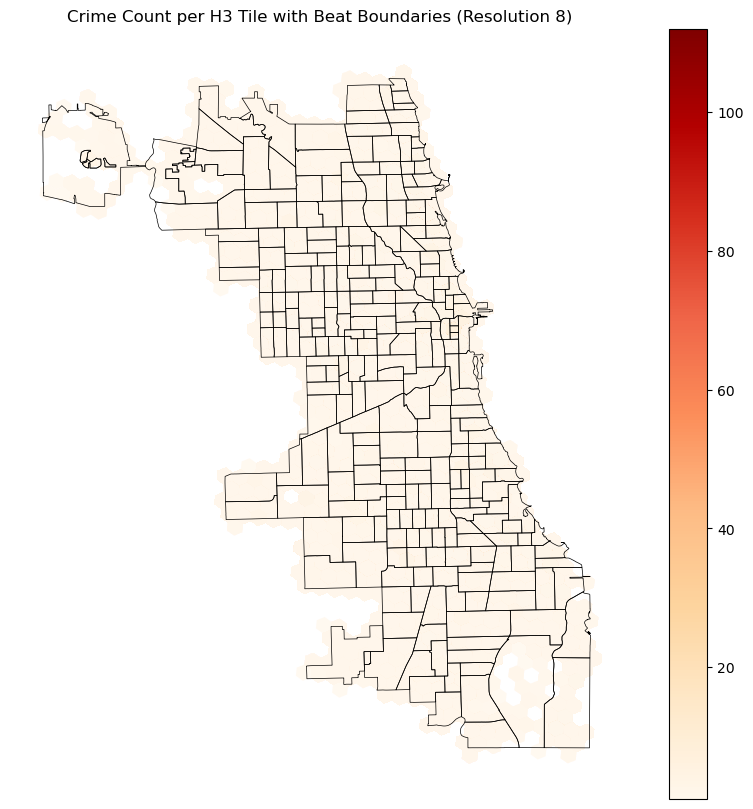

In [88]:
# Plot H3 crime intensity and overlay Chicago Beat boundaries
fig, ax = plt.subplots(figsize=(10, 10))

# Base layer: H3 tiles
gdf_tiles.to_crs("EPSG:4326").plot(
    column="crime_count",
    cmap="OrRd",
    legend=True,
    ax=ax,
    alpha=0.75
)

# Overlay: beat boundaries
beats_gdf.to_crs("EPSG:4326").boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.5
)

ax.set_title(f"Crime Count per H3 Tile with Beat Boundaries (Resolution {RESOLUTION})")
ax.set_axis_off()
plt.show()

In [89]:
# Create target variable by adding tiles where crime did not happen (zero crime)
# 1. Get all unique H3 addresses and all unique Dates in your study period
all_h3_tiles = crimes_df["h3_address"].unique()
all_dates = pd.date_range(start=crimes_df["Date"].min(), end=crimes_df["Date"].max())

# 2. Create a "Master Grid" using a MultiIndex (every tile x every date)
index = pd.MultiIndex.from_product([all_h3_tiles, all_dates.date], names=["h3_address", "Date"])
master_grid = pd.DataFrame(index=index).reset_index()

# 3. Merge actual crime counts onto this Master Grid
# Use a left join so we keep all (Tile, Date) combinations
final_df = pd.merge(master_grid, tile_counts, on=["h3_address", "Date"], how="left")

# 4. Fill the "No Crime" days with 0
final_df["crime_count"] = final_df["crime_count"].fillna(0)

# 5. Create your Binary Target Variable (The goal for the model is to predict if crime_count > 0)
final_df["target"] = (final_df["crime_count"] > 0).astype(int)

In [94]:
# Preview the master grid 
print("\n Sample master grid (target):")
final_df.head(3)


 Sample master grid (target):


,h3_address,Date,crime_count,target
0,882664cccbfffff,2022-01-01,2.0,1
1,882664cccbfffff,2022-01-02,1.0,1
2,882664cccbfffff,2022-01-03,1.0,1


---
### Step 3: Feature Engineering